In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

Importing plotly failed. Interactive plots will not work.


In [2]:
#Importing data
Beijing = pd.read_csv("D:/Math546 Time series/final projects/PM2.5 Data of Five Chinese Cities Data Set/BeijingPM20100101_20151231.csv")

In [3]:
#Delet non-useful data
Beijing.drop(['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'season', 'precipitation', 'Iprec'], 
               axis=1,
              inplace=True)

In [4]:
Beijing.dropna(axis=0, how="any",inplace=True)

In [5]:
# from datetime import datetime
Beijing['Time'] = pd.to_datetime(Beijing['year'].map(str) +"/"+ Beijing['month'].map(str) +"/"+ Beijing['day'].map(str)+" "+Beijing['hour'].map(str)+":00:00")
#Beijing

In [6]:
by_hour = Beijing.groupby(['Time']).mean()
print(by_hour.head())

                     No  year  month  day  hour  PM_US Post  DEWP  HUMI  \
Time                                                                      
2010-01-01 23:00:00  24  2010      1    1    23       129.0 -17.0  41.0   
2010-01-02 00:00:00  25  2010      1    2     0       148.0 -16.0  38.0   
2010-01-02 01:00:00  26  2010      1    2     1       159.0 -15.0  42.0   
2010-01-02 02:00:00  27  2010      1    2     2       181.0 -11.0  63.5   
2010-01-02 03:00:00  28  2010      1    2     3       138.0  -7.0  85.0   

                       PRES  TEMP   Iws  
Time                                     
2010-01-01 23:00:00  1020.0  -5.0  0.89  
2010-01-02 00:00:00  1020.0  -4.0  1.79  
2010-01-02 01:00:00  1020.0  -4.0  2.68  
2010-01-02 02:00:00  1021.0  -5.0  3.57  
2010-01-02 03:00:00  1022.0  -5.0  5.36  


In [7]:
by_hour.index = pd.to_datetime(by_hour.index, 
                             format='%d-%m-%Y %H:%M:%S')
by_hour = by_hour.set_index(by_hour.index).asfreq('H')
by_hour = by_hour.fillna(method='ffill')

print(by_hour.index)

DatetimeIndex(['2010-01-01 23:00:00', '2010-01-02 00:00:00',
               '2010-01-02 01:00:00', '2010-01-02 02:00:00',
               '2010-01-02 03:00:00', '2010-01-02 04:00:00',
               '2010-01-02 05:00:00', '2010-01-02 06:00:00',
               '2010-01-02 07:00:00', '2010-01-02 08:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='Time', length=52561, freq='H')


In [8]:
by_hour['Time'] = by_hour.index

In [9]:
data_13 = by_hour[(by_hour['Time'] >=pd.to_datetime('20130101030000')) & (by_hour['Time'] <= pd.to_datetime('20141231030000'))]

In [10]:
data_13 = data_13.set_index(data_13.index).asfreq('H')

In [11]:
#########################################################################################################

In [12]:
#Creat some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(data_13, label='PM_US Post')

features_and_target = pd.concat([X, y], axis=1)

In [13]:
# See our features and target
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PM_US Post
Time,,,,,,,,,
2013-01-01 03:00:00,3,1,1,1,2013,1,1,1,16.0
2013-01-01 04:00:00,4,1,1,1,2013,1,1,1,15.0
2013-01-01 05:00:00,5,1,1,1,2013,1,1,1,9.0
2013-01-01 06:00:00,6,1,1,1,2013,1,1,1,9.0
2013-01-01 07:00:00,7,1,1,1,2013,1,1,1,7.0


In [14]:
###############################################################################################################

In [15]:
#Plotting the Features to see trends

##Power demand has strong daily and seasonal properties.
##Day of week also seems to show differences in peaks.

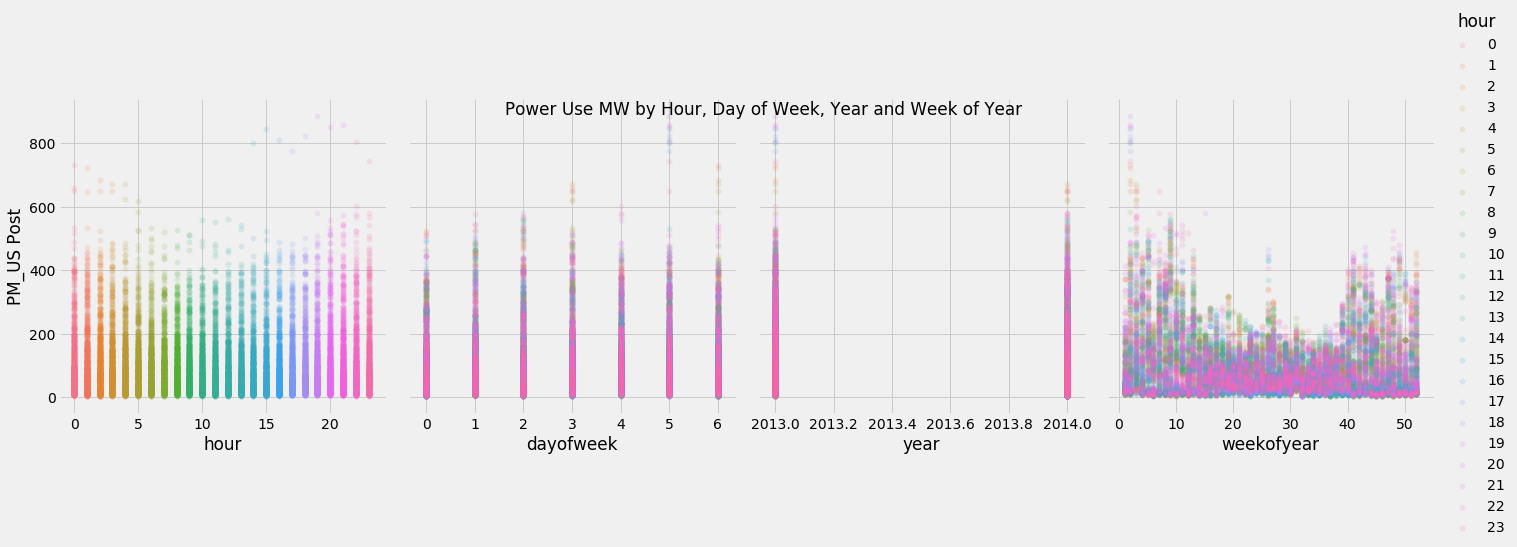

In [16]:
 sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PM_US Post',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

In [17]:
###############################################################################################################

In [18]:
#Train/Test Split
##Cut off the data after 2015 to use as our validation set. We will train on earlier data.

In [19]:
split_date = '2014-07-01 03:00:00'
data_13_train = data_13.loc[data_13.index <= split_date].copy()
data_13_test = data_13.loc[data_13.index > split_date].copy()

In [20]:
###############################################################################################################

In [21]:
# Format data for prophet model using ds and y
## Use parameter drop=True which not create new column with index but remove it

data_13_train.reset_index(drop=True) \
    .rename(columns={'Time':'ds',
                     'PM_US Post':'y'}).head()

,No,year,month,day,hour,y,DEWP,HUMI,PRES,TEMP,Iws,ds
0,26308.0,2013.0,1.0,1.0,3.0,16.0,-14.0,72.0,1018.0,-10.0,14.75,2013-01-01 03:00:00
1,26309.0,2013.0,1.0,1.0,4.0,15.0,-15.0,66.0,1018.0,-10.0,0.45,2013-01-01 04:00:00
2,26310.0,2013.0,1.0,1.0,5.0,9.0,-15.0,78.0,1019.0,-12.0,3.13,2013-01-01 05:00:00
3,26311.0,2013.0,1.0,1.0,6.0,9.0,-15.0,72.0,1020.0,-11.0,0.89,2013-01-01 06:00:00
4,26312.0,2013.0,1.0,1.0,7.0,7.0,-16.0,45.0,1020.0,-6.0,4.92,2013-01-01 07:00:00


In [22]:
# Setup and train model and fit
model = Prophet()
model.fit(data_13_train.reset_index(drop=True) \
              .rename(columns={'Time':'ds',
                               'PM_US Post':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [23]:
# Predict on training set with model
df_test_fcst = model.predict(df=data_13_test.reset_index(drop=True) \
                                   .rename(columns={'Time':'ds'}))

In [24]:
df_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-07-01 04:00:00,41.654574,-79.963264,159.502768,41.654574,41.654574,-1.269314,-1.269314,-1.269314,1.557857,1.557857,1.557857,-2.827172,-2.827172,-2.827172,0.0,0.0,0.0,40.385260
1,2014-07-01 05:00:00,41.621574,-83.188387,153.670220,41.621574,41.621574,-3.961759,-3.961759,-3.961759,-1.368717,-1.368717,-1.368717,-2.593042,-2.593042,-2.593042,0.0,0.0,0.0,37.659815
2,2014-07-01 06:00:00,41.588575,-81.905995,158.336313,41.588575,41.588575,-4.865691,-4.865691,-4.865691,-2.507490,-2.507490,-2.507490,-2.358202,-2.358202,-2.358202,0.0,0.0,0.0,36.722883
3,2014-07-01 07:00:00,41.555575,-79.194342,149.397684,41.555575,41.555575,-5.119313,-5.119313,-5.119313,-2.992909,-2.992909,-2.992909,-2.126404,-2.126404,-2.126404,0.0,0.0,0.0,36.436262
4,2014-07-01 08:00:00,41.522576,-84.059644,142.911762,41.522576,41.522576,-6.118432,-6.118432,-6.118432,-4.217115,-4.217115,-4.217115,-1.901317,-1.901317,-1.901317,0.0,0.0,0.0,35.404144


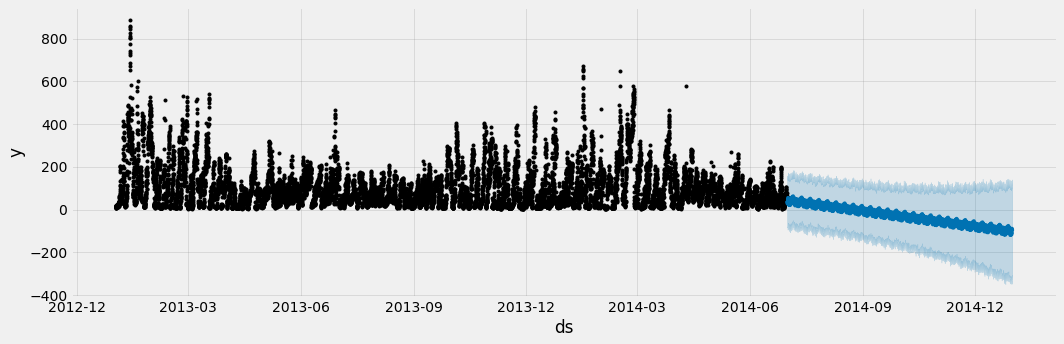

In [25]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df_test_fcst,
                 ax=ax)
plt.show()

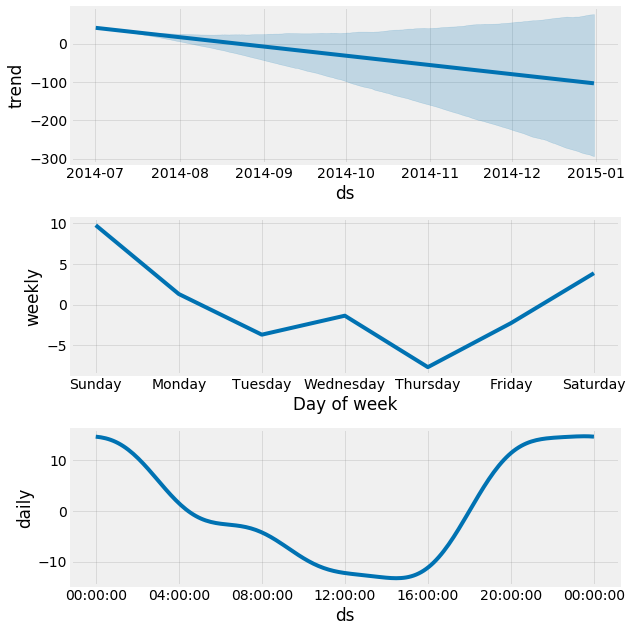

In [26]:
# Plot the components of the model
fig = model.plot_components(df_test_fcst)

In [27]:
###############################################################################################################

In [28]:
#Compare Forecast to Actuals

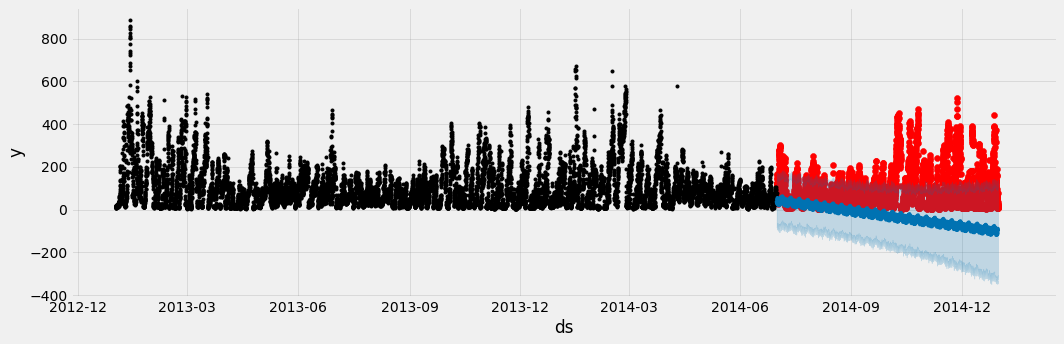

In [29]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_13_test.index, data_13_test['PM_US Post'], color='r')
fig = model.plot(df_test_fcst, ax=ax)

In [30]:
#Look at first month of predictions

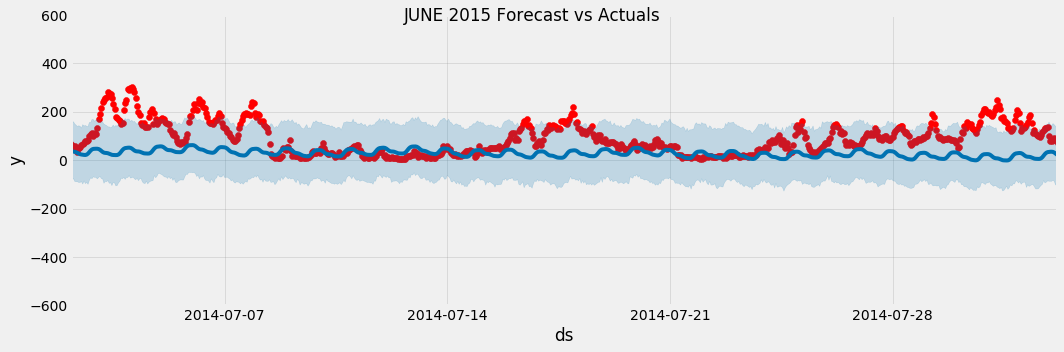

In [31]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_13_test.index, data_13_test['PM_US Post'], color='r')
fig = model.plot(df_test_fcst , ax=ax)

ax.set_xbound(lower=pd.to_datetime('20140702040000'),
              upper=pd.to_datetime('20140802040000'))
ax.set_ylim(-600, 600)
plot = plt.suptitle('JUNE 2015 Forecast vs Actuals')

In [32]:
###############################################################################################################

In [33]:
#Single Week of Predictions

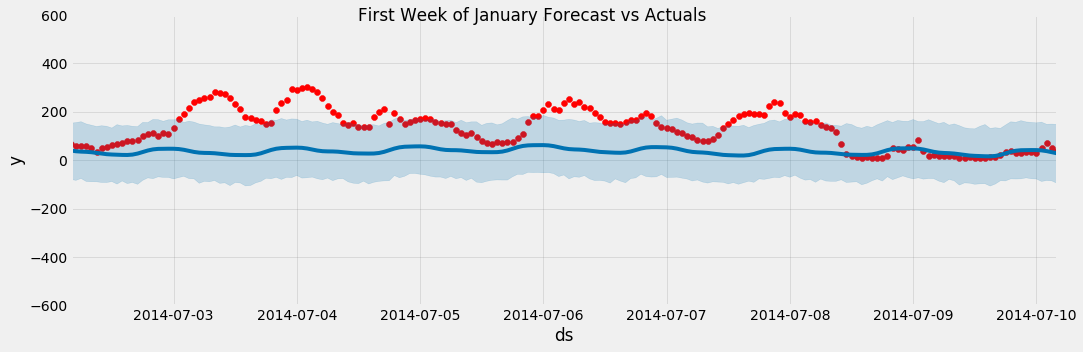

In [34]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_13_test.index, data_13_test['PM_US Post'], color='r')
fig = model.plot(df_test_fcst , ax=ax)

ax.set_xbound(lower=pd.to_datetime('20140702040000'),
              upper=pd.to_datetime('20140710040000'))
ax.set_ylim(-600, 600)
plot = plt.suptitle('First Week of January Forecast vs Actuals')